In [1]:
import pyaudi as pa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn 
seaborn.set_style("whitegrid")

from Utils import DA as da 
from Utils.RK4 import RK4

# Goal
Rewrite a differential equation with independent variable [0,1] and use tf as an expansion variable, in addition to initial conditions. Demonstrate that the expansion is accurate.

Define some nonlinear dynamics with a parameter to include in the expansion

In [2]:
def dyn(x, t, p, tf):
    dx1 = x[1]
    dx2 = -x[0] + p*(1-x[0]**2)*x[1]
    return np.array([dx1,dx2])*tf

Let's look at a few sample paths

(1000L, 2L, 50L)


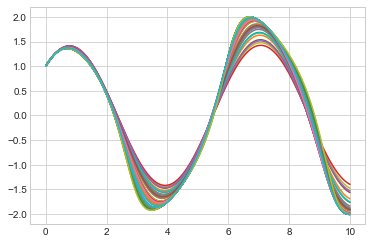

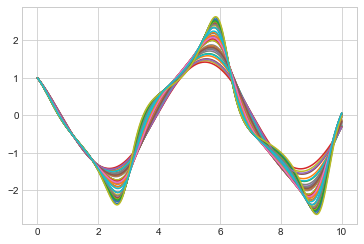

In [27]:
tf = 10
N = 50
x0 = 2*np.random.random((2,N))
x0 = np.ones_like(x0) # Deterministic ic
p = np.random.random((N,))

t = np.linspace(0,1,1000) # Idea - could we make the entire t array DA variables and expand that way? Then move the points optimally?!
x = RK4(dyn, x0, t, (p,tf))

print x.shape
for xi in np.transpose(x,(2,1,0)):
    plt.figure(1)
    plt.plot(t*tf, xi[0])
    plt.figure(2)
    plt.plot(t*tf, xi[1])
plt.show()

(1000L, 2L, 50L)


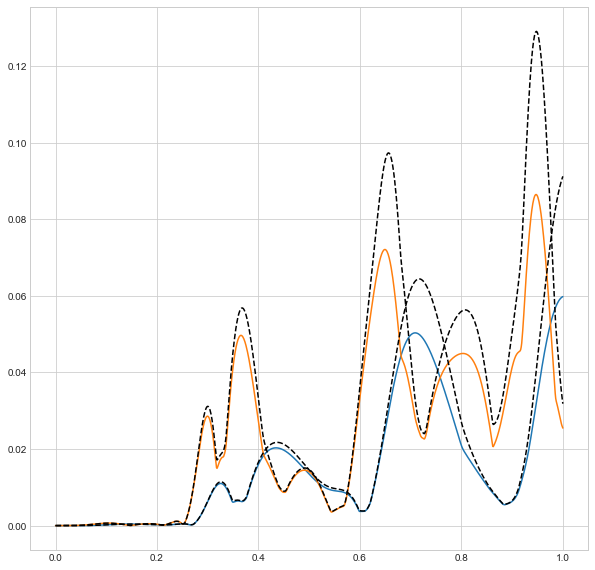

In [32]:
names = ['x','y','p','tf']
x0_nom = np.array([1,1])
p_nom = np.mean(p)
tf_nom = tf
x0_da = da.make([x0_nom[0],x0_nom[1],p_nom,tf_nom], names, 2)
x_da = RK4(dyn, x0_da[0:2], t, (x0_da[2], x0_da[3]))


delta = np.concatenate((x0.T-x0_nom, p[:,None]-p_nom, tf*np.ones_like(p[:,None])-tf_nom),axis=1)

# Verify we're evaluating at the correct points - these should match perfectly 
# print x0.T[0]
# print da.evaluate(x_da[0], names, delta[:1])[0]

x_eval = np.array([da.evaluate(x_da_i, names, delta).T for x_da_i in x_da])
print x_eval.shape

error = np.abs(x-x_eval)
err_mean = np.mean(error, axis=2)
err_var = np.var(error, axis=2)

plt.figure(1,figsize=(10,10))
plt.plot(t, err_mean)
plt.plot(t, err_mean+3*err_var, 'k--')
# plt.plot(t, err_mean-3*err_var, 'k--')

plt.show()

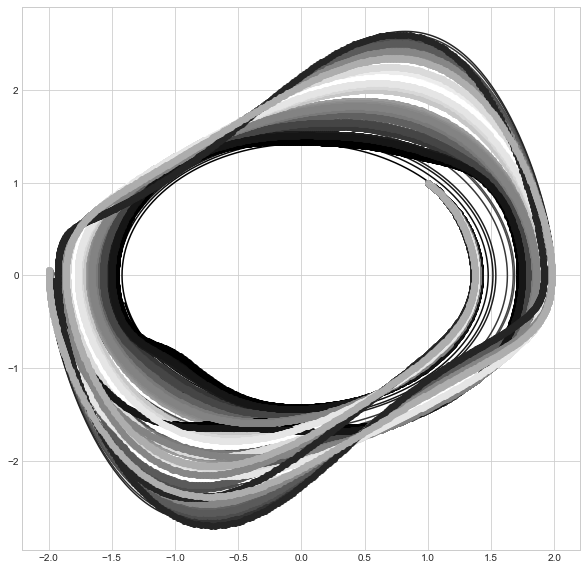

In [33]:
colors = np.linalg.norm(delta, axis=1)
colors = 1-(colors - colors.min())/(colors.max()-colors.min()) # Largest perturbations are black

# plot = plt.plot 
# for err,color in zip(np.transpose(error,(2,0,1)),colors):
#     plt.figure(1)
#     plot(t*tf, err[:,0], color='{}'.format(color))
#     plt.figure(2)
#     plot(t*tf, err[:,1], color='{}'.format(color))
plt.figure(figsize=(10,10))
for xi,color in zip(np.transpose(x,(2,1,0)),colors):
#     plt.plot(t*tf, xi.T)
    plt.plot(xi[0], xi[1],color='{}'.format(color))
    
for xi,color in zip(np.transpose(x_eval,(2,1,0)),colors):
    plt.plot(xi[0], xi[1], 'o--', color='{}'.format(color))    
    
plt.show()

# Next goal - Saturation
Determine how well DA can compensate with saturation via hyperbolic tangent. In the past it seem the error was acceptable.

In [2]:
def dyn_sat(x, t, tf=5):
    dx1 = x[1]
    dx2 = np.clip((-x[0] + 1*(1-x[0]**2)*x[1]),-1,1)
    return np.array([dx1,dx2])*tf

# from Utils.DA import clip 
def dyn_tanh(x, t, tf=5):
    dx1 = x[1]
    dx2 = da.clip((-x[0] + 1*(1-x[0]**2)*x[1]),-1,1)
    return np.array([dx1,dx2])*tf

In [3]:
N = 5
x0 = (np.array([1,1]) + np.random.normal(size=(N,2))/30).T
t = np.linspace(0,1)
x = RK4(dyn_sat, x0, t)

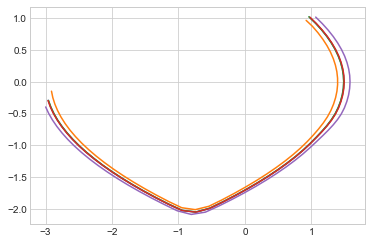

In [4]:
for xi in np.transpose(x,(2,1,0)):
#     plt.figure(1)
#     plt.plot(t, xi[0])
#     plt.figure(2)
#     plt.plot(t, xi[1])
    plt.figure(3)
    plt.plot(xi[0],xi[1])
plt.show()

(50, 2, 5)


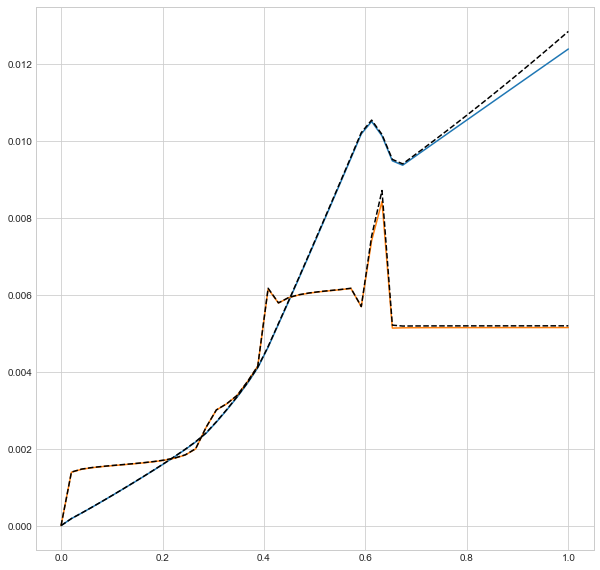

In [7]:
names = ['x','y']
x0_nom = np.array([1.,1.])
x0_da = da.make(x0_nom, names, 3)
x_da = RK4(dyn_tanh, x0_da, t)


delta = x0.T-x0_nom

# Verify we're evaluating at the correct points - these should match perfectly 
# print x0.T[0]
# print da.evaluate(x_da[0], names, delta[:1])[0]

x_eval = np.array([da.evaluate(x_da_i, names, delta).T for x_da_i in x_da])
print(x_eval.shape)

error = np.abs(x-x_eval)
err_mean = np.mean(error, axis=2)
err_var = np.var(error, axis=2)

plt.figure(1,figsize=(10,10))
plt.plot(t, err_mean)
plt.plot(t, err_mean+3*err_var, 'k--')
plt.show()

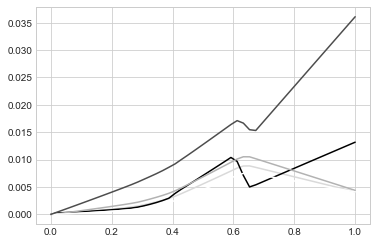

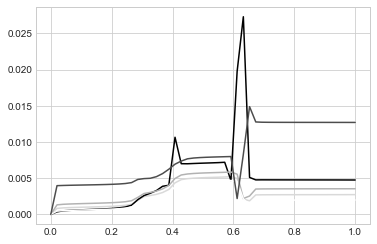

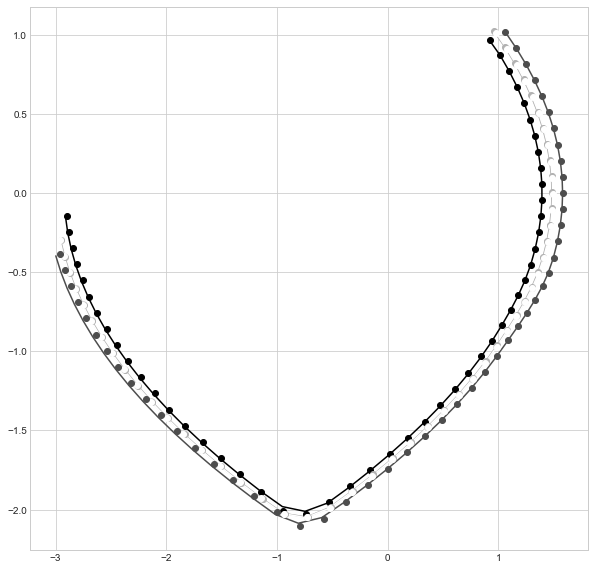

In [10]:
colors = np.linalg.norm(delta, axis=1)
colors = 1-(colors - colors.min())/(colors.max()-colors.min()) # Largest perturbations are black

tf = 1
plot = plt.plot 
for err,color in zip(np.transpose(error,(2,0,1)),colors):
    plt.figure(1)
    plot(t*tf, err[:,0], color='{}'.format(color))
    plt.figure(2)
    plot(t*tf, err[:,1], color='{}'.format(color))

plt.figure(figsize=(10,10))
for xi,color in zip(np.transpose(x,(2,1,0)),colors):
#     plt.plot(t*tf, xi.T)
    plt.plot(xi[0], xi[1],color='{}'.format(color))
    
for xi,color in zip(np.transpose(x_eval,(2,1,0)),colors):
    plt.plot(xi[0], xi[1], 'o', color='{}'.format(color))    
    
plt.show()